# The MNIST Experiment
> "As part of FastAI DL Course V4 Chapter 4 we will be creating an MNIST Digit Classifier."

- toc: false
- badges: true
- comments: false
- categories: [fastai, vision]
- hide: true
- search_exclude: true

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
import pandas as pd
from fastbook import *
from fastai.vision.all import *
from ipywidgets import GridspecLayout

In [3]:
#hide

# Function used to create a new grid for presenting results in the data gathering
def create_grid(size):
    grid = GridspecLayout(size+1, 4)
    out = widgets.Output(layout={'border': '1px solid black'})
    out.append_stdout('Digit/Folder')
    grid[0, 0] = out
    out = widgets.Output(layout={'border': '1px solid black'})
    out.append_stdout('Total Images')
    grid[0, 1] = out
    return grid

# Function used to create a new grid for presenting results in the data gathering
def create_image_grid(size):
    grid = GridspecLayout(size+1, 4)
    return grid

# Function that will process a row for the grid
def process_row(grid, index, label, size):
    out = widgets.Output()
    out.append_stdout(str(label))
    grid[index+1, 0] = out
    out = widgets.Output()
    out.append_stdout(str(size))
    grid[index+1, 1] = out


## Welcome!

Hello and welcome to another of my adventures! Today we will be building a neural network using the MNIST Digits Data Set for digit detection. 

We will have a chance to *”decompose”* a simple neural network, see how it looks from the inside, we will create our loss function, accuracy metric and see how a network learns, all within this exercise.

I’m so excited to share this with you and I want to say that doing this small project was and still is **one of my favorite projects I have ever done**.

Now before we start I should say, I had some issues with math, I forgot a lot of calculus and had to go back and relearn some concepts. In an effort to help other people that might have had the same struggle I'll be writing another post to cover some small, coding and calculus concepts that made this exercise much easier to resolve.

Finally I would like to say this exercise is based on (FastAI Course)[course.fast.ai] Lesson 4, in case you want to review some further details regarding this and other exercises.

### Data Structure Review
First things first, let's unpack the data and review it. FastAI already has a way for us to download the MNIST data set in full. We will download it, unpack it, and see its contents.

Some key questions we want answers for are:

* How is the data structured?
* Does it have a validation set?
* How is the data labeled?


In [4]:
path = untar_data(URLs.MNIST)

In [5]:
#hide
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]


Ok so we can see the data is divided into 2 separate data sets, testing (validation) and training sets and each of them contains a folder that identifies the digit of the images it contains. We should be able to examine the contents of one of the folders and render one of the images.


In [6]:
(path/'training').ls().sorted(), (path/'testing').ls().sorted()

((#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')],
 (#10) [Path('testing/0'),Path('testing/1'),Path('testing/2'),Path('testing/3'),Path('testing/4'),Path('testing/5'),Path('testing/6'),Path('testing/7'),Path('testing/8'),Path('testing/9')])

In [7]:
Image.open((path/'training'/'8').ls().sorted()[999])


It looks like a very simple image that contains the digit number in black and white. As we saw from the details above I think we have a way to answer our questions and that will help us generate our dataset:

#### How is the data structured?

*We have 2 folders 1 for the training data and one for testing data.*

#### Does it have a validation set?

*Yes*

#### How is the data labeled?

*Within each of the folders (testing and training) we have child folders that represent the digits and finally within those we have our data*

### Data Set Definition

Using the answers from the questions above we need to come up with a small script that helps us build our data set.

Here are the criteria for building our script:

1. Grab the images within our training and testing folders
1. Traverse each folder structure in order to grab all the digit folders within.
1. Grab the images within each digit folder and store them in a way we can label and use them for training and validation.
1. Use the folder names to generate our labels for each of the images


In [8]:
# This grid will be used for tracking our results from processing the images
training_results = create_grid(len((path/'training').ls().sorted()))

# First lets grab all of our images and store the corresponding paths in a list so that we can read them
training_folders = (path/'training').ls().sorted()
training_paths = []

# This tensor will contain the label for each of the images in the data set
train_y = tensor([])

# Index for our grid
index = 0

# We need to loop over the different paths and then grab the paths to all of our images sorted
# so that we can load the image into a tensor we can use to pass it to model
for digits in training_folders:
    
    # Grab the digit label in the path of the folder
    label = re.findall("\d",str(digits))
    
    # Create a label tensor with equal to the number of images for the digit
    label_tensor = tensor([float(label[0])]*len(digits.ls()))
    train_y = torch.cat((train_y, label_tensor),0)
    
    # Grab all the paths to our images
    training_paths += digits.ls().sorted()
    
    # Display our results
    process_row(training_results, index, label[0],len(digits.ls()))
    index+=1

train_y = train_y.type(torch.LongTensor)

# We can check the our array of paths tensor shape should be (total number images in all folders)
training_results

GridspecLayout(children=(Output(layout=Layout(border='1px solid black', grid_area='widget001'), outputs=({'out…


Now that we have our *training_paths* we can use it to open the images, map the pixel values to a tensor and finally divide them by 255 since we want values that fit between 0 and 1 for the pixel images.


In [9]:
# Final we should be able to open the image and store it as a tensor
train_data = torch.stack([tensor(Image.open(o)) 
                             for o in training_paths.sorted()]).float()/255
    
# We can check the our tensor shape should be (total number images, with a 28 by 28 size) Rank 3 tensor
train_data.shape, train_y.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))


### Validation Data Set

Once we have processed the training data set we can perform the same routine to the validation data set so that we can:

1. Collecto all the validation set images
1. Generate labels for all the images
1. Process the images in a way our model can read it


In [10]:
validation_results = create_grid(len((path/'training').ls().sorted()))
validation_labels = (path/'testing').ls().sorted()
validation_paths = []
index = 0
valid_y = tensor([])

for digits in validation_labels:
    label = re.findall("\d",str(digits))
    label_tensor = tensor([float(label[0])]*len(digits.ls()))
    valid_y = torch.cat((valid_y, label_tensor),0)
    validation_paths += digits.ls().sorted()
    process_row(validation_results, index, label[0],len(digits.ls()))
    index+=1

valid_y = valid_y.type(torch.LongTensor)
validation_results

GridspecLayout(children=(Output(layout=Layout(border='1px solid black', grid_area='widget001'), outputs=({'out…

In [11]:
valid_data = torch.stack([tensor(Image.open(o)) 
                               for o in validation_paths]).float()/255
valid_data.shape, valid_y.shape

(torch.Size([10000, 28, 28]), torch.Size([10000]))


### Data Review

When dealing with images something that really helped me was to visualize what was going to happen and experiment a little with the data. Jeremy did something similar in the course where he opened the image so we can see the underlying data and try to understand and figure out how the machine would process it.

So in the next cell we will be grabbing one of the images in the training data, open it with pandas and render the contents using a data frame grid.



In [12]:
#hide_output
a_digit = train_data[51000,:,6:24]
df = pd.DataFrame(a_digit)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.125490,0.580392,0.992157,0.992157,0.313726,0.000000,0.000000,0.215686,0.580392,0.486275,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.745098,0.988235,0.988235,0.988235,0.952941,0.188235,0.203922,0.909804,0.988235,0.882353,0.082353,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.035294,0.568627,0.968627,0.988235,0.988235,0.988235,0.874510,0.125490,0.498039,0.988235,0.988235,0.980392,0.227451,0.000000,0.000000
8,0.000000,0.000000,0.062745,0.729412,0.992157,0.988235,0.968627,0.741176,0.568627,0.137255,0.000000,0.772549,0.988235,0.988235,0.725490,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.250980,0.988235,0.992157,0.988235,0.388235,0.000000,0.000000,0.000000,0.454902,0.976471,0.988235,0.815686,0.070588,0.000000,0.000000,0.000000



### Tuples and Data Sets
In the next section we will transform the training images like the one above into a vector by stacking all the pixels into 1 big column, and, create a [tuple](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) with the vectorized image and the corresponding label.

Finally we will create a list of those tuples which will give us our 2 final data sets.


In [13]:
# This function will concatenate all images into 1 tensor and will make it a rank 2 tensor. 
# The 1st value is the index and 2nd will be the image decomposed into a vector
train_x = train_data.view(-1, 28*28)
valid_x = valid_data.view(-1, 28*28)

train_x.shape, valid_x.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [14]:
train_dset = list(zip(train_x,train_y))
valid_dset = list(zip(valid_x,valid_y))

We can now see that the same image above has been transformed into a vector and is followed by the corresponding label at the end of the tuple. (The numbers bellow represent the image above)

In [15]:
train_dset[51000]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0


### Data Loaders

FastAI has a class that will help us perform the training and validation of our model by generating a mini batch of data that will be processed by the model when training.

The Data Loader class can be used even if we are not using a fully developed *cnn_learner* from FastAI, like, when we are defining our learner manually.

Something I thought was very cool was that this decoupling of the architecture helps when people want to build a customized model; we have libraries, classes or pieces of code we can reuse. We don't have to reinvent the wheel to create a class or method that help us load our data to our model


In [16]:
# First lets define our data loader instances 1 per dataset
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)

# Next we will crate our neural network which will use the DataLoaders class that
# holds our training and validation dataset
dls = DataLoaders(train_dl, valid_dl)


### Accuracy and Loss
These are 2 concepts that as Jeremy explained in the course can often be confused because you could say reflect the same or very similar information that reflects the model performance.

* Accuracy could be represented as the *average* of correct predictions in a model.
* Loss could be represented as using the current learning rate, input and parameters for how much should we "update" (step) our weights to improve our predictions, think of it as the *penalty for making a bad prediction*.

The loss is used in *Gradient Descent* by the machine to understand with that *penalty* or “punishment” if the parameters should be updated or not depending on the result of the prediction; taking into account that the loss function will penalize/punish heavily on worse predictions or lightly on better predictions.

On the other hand *accuracy* is what helps us, humans, understand the performance of our model so that we can understand and make decisions on whether we should be altering [hyperparameters](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) used by the learning process (batch size, number of epochs) to improve the performance of our model.


In [17]:
# This accuracy function will calculate the accuracy comparing the max values of the
# inputs using argmax to get the max values of the passed inputs and then checking it agaist the
# targets and finally calculate the mean

def batch_accuracy(xb, yb):
    xb = np.argmax(xb, 1)
    correct = (xb==yb)
    return correct.float().mean()

In [18]:
def mnist_loss(predictions, targets):
    # When using softmax we need to ensure the number of activations in our
    # last layer matches the number of classes for our model predictions in this case should be 10
    predictions = torch.log_softmax(predictions, 1)
    return F.nll_loss(predictions, targets)


### The Neural Network

Finally we have reached the moment to create our neural network. You will see that the network is actually not really complex and you might be surprised that its composed of 3 functions, and how much it can do with only those 3 layers Here is the entire definition of a neural net the function is actually small, and it has 3 different components:
```
simple_net(xb){
  res = xb@w1 + b1
  res = res.max(tensor(0.0))
  res = res@w2 + b2
  return res
}
```

1. Layer that performs a matrix multiplication using the values of the image we are trying to predict times the layer 1 weights then adds it up with a bias.
2. Rectifier linear unity which will max the result of the previous operation layer.
3. Another layer which will perform a matrix multiplication with the result of the previous operation times the weights of layer 2 and adds it up again to bias of layer 2.


In [19]:
#hide

# I defined more layers to this simple net in case you want to try it out
simple_net = nn.Sequential(
    nn.Linear(28*28,784),
    nn.ReLU(),
    nn.Linear(784,784),
    nn.ReLU(),
    nn.Linear(784,784),
    nn.ReLU(),
    nn.Linear(784,40),
    nn.ReLU(),
    nn.Linear(40,10)
)

# Use this variable to render layers of this network if not use the one in the render cell
layers_to_render = [0, 2 ,4]

In [20]:
# Our very simple neural net
simple_net = nn.Sequential(
    nn.Linear(28*28,50),
    nn.ReLU(),
    nn.Linear(50,10)
)


### Learner Module
FastAI has a learner module that enables us to use our own model, optimizer, loss and metrics. The module would help us with:

* Executing the training epochs.
* Call our optimizer to update our parameters.
* Using the data loaders pass the mini batches to the training.
* Call our metric functions.
* Give us an output of our training.

I found this module very helpful, similarly to the DataLoaders module, the learner module decouples the API and for more advanced people enables them to customize every detail on the model and how they want to optimize the weights, metrics they want to use and more.


In [21]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [24]:
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.090545,0.108007,0.966200,00:01
1,0.088196,0.104899,0.966700,00:02
2,0.090239,0.108342,0.966000,00:01
3,0.087355,0.104934,0.967000,00:02
4,0.080858,0.102985,0.968600,00:02
5,0.081753,0.101288,0.968400,00:02
6,0.079057,0.100700,0.968800,00:02
7,0.078785,0.098953,0.969800,00:01
8,0.073720,0.101644,0.968800,00:02
9,0.075326,0.097657,0.970700,00:01



### Visualizing Layer Features

In this final section we will use the parameters stored in our model and generate a small image. I loved this part of the exercise since it's where we can see how our network defines the features on the layer/s.

The *nn.Sequential* function used in our model stores the different functions in a list. We can use the index to grab the layer we want to use for the rendering (which is layer 0).

```
simple_net[0].parameters()
```

You will see that the line above contains a tensor with 50 features each containing a vector of size 784. We will use what we did in the past to transform the vector into a 28x28 tensor and finally use the *[show_images](https://docs.fast.ai/torch_core.html#show_images)* method to render that tensor as an image.


In [25]:
# We can extract the parameters (wieghts and bias) of the layers
w, b = simple_net[0].parameters()
w.shape

torch.Size([50, 784])

In [29]:
#hide_output
# We can also render a feature using pandas and do it on a grey scale
df2 = pd.DataFrame(w[10].view(28,28))
df2.style.set_properties(**{'font-size':'1pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.009312,0.024448,-0.030928,0.019658,0.007727,-0.026603,0.023343,0.007251,0.018537,0.012879,0.013386,-0.029914,0.014591,0.035322,0.032974,0.005959,0.017584,0.035607,-0.021590,-0.026640,0.006470,0.021080,-0.031226,0.034219,-0.016323,0.001253,0.034644,-0.005056
1,-0.019328,0.011370,-0.016451,0.027297,0.026522,0.017778,0.004411,-0.018127,0.026360,-0.012520,-0.031697,-0.011959,-0.005570,-0.028296,0.026677,-0.003296,0.027737,-0.002588,0.006560,0.009732,-0.033943,-0.011969,0.035406,-0.003394,-0.026766,-0.006362,0.007484,-0.022250
2,0.032174,-0.029021,0.004276,-0.018459,-0.026912,-0.025224,0.020070,0.017090,-0.017820,0.005445,0.027067,0.006988,0.024149,0.036578,-0.020030,0.037892,-0.007836,-0.009485,0.035685,-0.000101,-0.008047,-0.032485,0.026092,0.009068,0.028374,0.020926,0.015179,0.002894
3,0.027648,0.004653,0.023427,0.025294,-0.009847,-0.006157,-0.025277,-0.028965,-0.028356,0.046775,0.031365,0.005454,0.009442,0.047168,-0.019098,0.011439,0.030230,0.030661,-0.020585,0.009781,-0.018282,0.013391,-0.030860,-0.030567,0.015530,0.012129,0.030508,-0.008607
4,-0.024681,-0.005763,-0.032285,-0.012367,0.025345,-0.022902,-0.022963,-0.035335,0.014349,0.039959,0.034026,0.078482,0.071954,0.069125,0.056461,0.058103,0.061172,0.058434,0.070321,0.049863,0.005830,0.019179,-0.037222,0.015973,0.005577,0.033860,-0.008996,-0.006083
5,0.000458,-0.016033,-0.025509,-0.024579,0.015970,-0.016672,-0.030048,-0.016134,-0.071602,0.002299,0.063249,0.054873,0.065676,0.053976,0.048844,0.058185,0.119580,0.116242,0.146550,0.051707,0.063744,0.063762,0.048614,-0.020106,0.007628,0.034875,-0.025860,0.018477
6,-0.022792,-0.022002,-0.029016,0.002684,-0.026329,-0.051539,-0.071908,-0.019443,-0.026272,-0.022816,0.071583,0.055262,0.084867,0.033771,0.101458,0.079652,0.125435,0.068028,0.088483,0.023379,0.027945,-0.038456,0.039876,0.005347,0.030732,0.057948,0.000441,-0.017676
7,-0.003016,0.012217,-0.020185,-0.000525,-0.022745,-0.035083,-0.054082,-0.011547,0.027832,0.028899,0.032677,0.071936,0.030856,0.056181,0.127062,0.129553,0.130020,-0.025971,0.071440,0.022480,-0.017178,0.055556,0.033663,0.031672,-0.001897,0.044430,-0.021651,-0.015704
8,-0.002104,0.018726,-0.040465,0.008059,-0.053012,-0.082069,0.005242,-0.013801,0.044785,0.011713,0.065261,0.054122,0.075161,0.122547,0.049351,-0.016802,0.067682,0.084772,-0.021454,0.017212,-0.062311,0.007464,-0.009136,-0.000557,0.063306,0.026783,-0.007053,0.018326
9,-0.010997,-0.005362,-0.025074,-0.039699,-0.006335,-0.000675,-0.003818,0.036764,0.036802,0.028624,0.070161,0.083198,0.041028,0.029698,-0.017637,-0.002602,0.004900,-0.030892,-0.014284,-0.074635,-0.079666,-0.042673,-0.056741,0.041745,0.070001,0.112384,-0.002132,-0.016000


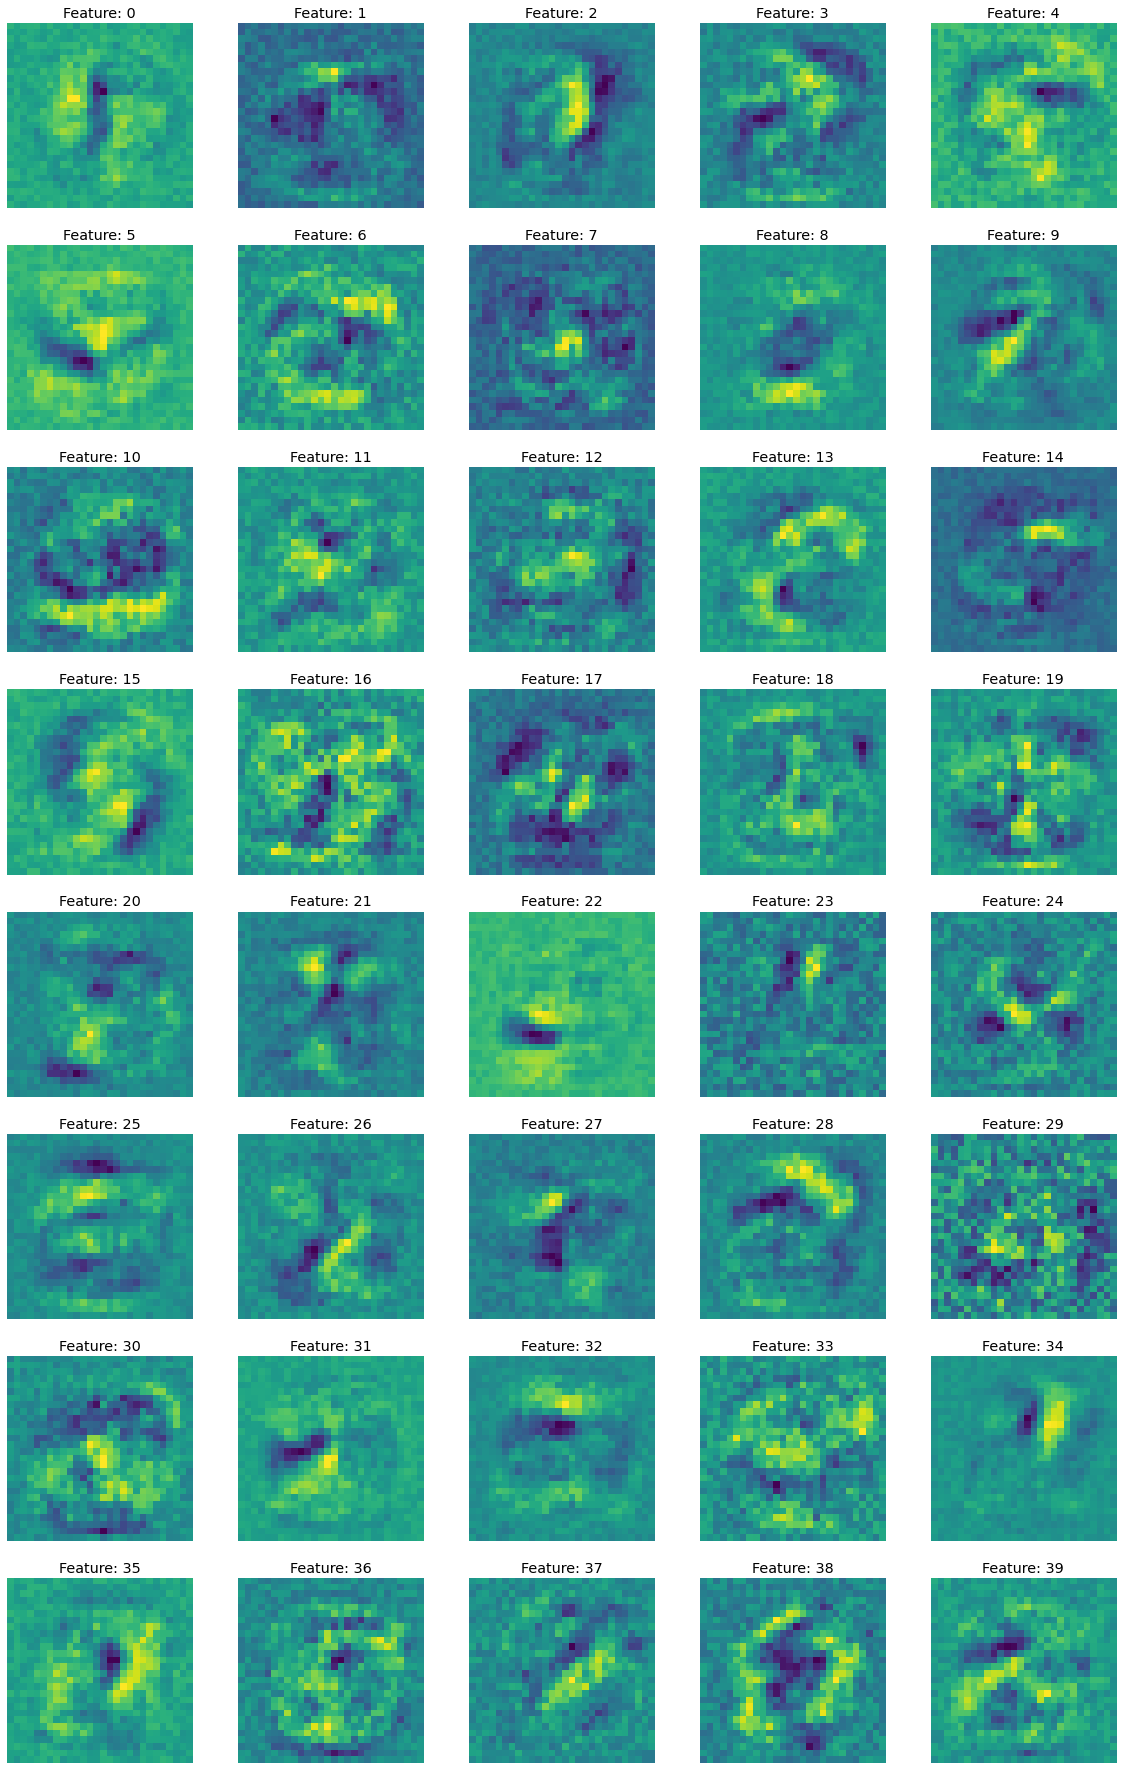

In [30]:
# These are variables we are using to loop and get the features and layers to render
layer_index = 0 
layers_to_render = [0]

# We will use these arrays to store the images and the titles of each of them
images = []
titles = []

# Finally let's loop the layers of the nn.Sequetial
for layer in simple_net:
    if layer_index in layers_to_render:
        index = 0;
        w, b = layer.parameters()
        
        # Finally we can change the tensor to a 28 by 28 to render the layers
        for feature in w:
            images.append(feature.view(28,28))
            titles.append(str(f'Feature: {index}'))
            index+=1
    layer_index+=1

show_images(images, titles=titles, nrows=8, ncols=5, imsize=4)

### Summary
Thank you so much for reaching the end, I really appreciate you taking the time to reading and reviewing my post and joining me in my journey through Deep Learning.

Today with this exercise we learned about the different modules FastAI exposes and how we can use them to build our custom model.

We created our accuracy and loss function and also loaded the data into data loaders that helped us when we were training our model.

Finally we explored the parameters resulting of the training and a potential path to render the parameters of a network to see the different features a model might use, and how they look

I hope this was helpful and useful to you. If you were following the exercise that you found it interesting and fun to build.

Thanks again and see you on my next adventure.


### Resources and References

* https://course.fast.ai/videos/?lesson=4
* https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences
* https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/